In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [40]:
sent = pd.read_csv("fear_greed_index - fear_greed_index.csv")
trades = pd.read_csv("historical_data - historical_data.csv")

In [41]:
print("sentiment:", sent.shape)
print("trades:", trades.shape)
sent.info()
trades.info()

sentiment: (2644, 4)
trades: (211224, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  ob

In [42]:
print("missing sentiment\n", sent.isna().sum())
print("missing trades\n", trades.isna().sum())
print("dup sentiment:", sent.duplicated().sum())
print("dup trades:", trades.duplicated().sum())

missing sentiment
 timestamp         0
value             0
classification    0
date              0
dtype: int64
missing trades
 Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64
dup sentiment: 0
dup trades: 0


In [43]:
trades['Timestamp'] = pd.to_datetime(trades['Timestamp'], unit='ms')
trades['date'] = trades['Timestamp'].dt.date
sent['date'] = pd.to_datetime(sent['date']).dt.date

In [44]:
df = trades.merge(sent, left_on='date', right_on='date', how='left')
df[['date','classification']].head()
print("rows without sentiment:", df['classification'].isna().sum())

rows without sentiment: 26961


In [45]:
df['win'] = df['Closed PnL'] > 0
df['long'] = df['Side'].astype(str).str.upper().isin(['BUY','LONG']).astype(int)

In [46]:
daily = (
    df.groupby(['Account','date','classification'])
      .agg(daily_pnl=('Closed PnL','sum'),
           trades=('Account','count'),
           avg_size=('Size USD','mean'),
           long_ratio=('long','mean'),
           win_rate=('win','mean'))
      .reset_index()
)

daily['pnl_per_trade'] = daily['daily_pnl'] / daily['trades']
daily.head()

,Account,date,classification,daily_pnl,trades,avg_size,long_ratio,win_rate,pnl_per_trade
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-10-27,Greed,-3.275059e+05,462,14810.891818,0.300866,0.025974,-708.887230
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-19,Fear,1.927736e+06,3356,16345.241940,0.468415,0.405542,574.414696
2,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2024-10-27,Greed,2.060745e+04,320,2492.749906,0.453125,0.531250,64.398269
3,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-02-19,Fear,1.709873e+04,3533,1693.351684,0.432494,0.435041,4.839719
4,0x271b280974205ca63b716753467d5a371de622ab,2024-07-03,Neutral,-1.000000e+00,5,6070.200000,0.400000,0.000000,-0.200000


In [47]:
daily = daily.sort_values(['Account','date'])

daily['cum_pnl'] = daily.groupby('Account')['daily_pnl'].cumsum()
daily['peak'] = daily.groupby('Account')['cum_pnl'].cummax()
daily['drawdown'] = daily['cum_pnl'] - daily['peak']

In [48]:
daily.groupby('classification')[['daily_pnl','win_rate','drawdown','pnl_per_trade']].mean()

,daily_pnl,win_rate,drawdown,pnl_per_trade
classification,,,,
Extreme Greed,35393.098355,0.336609,-1112.803228,-30.861185
Fear,209372.662205,0.415878,-2496.129364,100.862767
Greed,99675.516731,0.374074,0.000000,258.638973
Neutral,19842.797260,0.260683,-3917.470960,28.877718


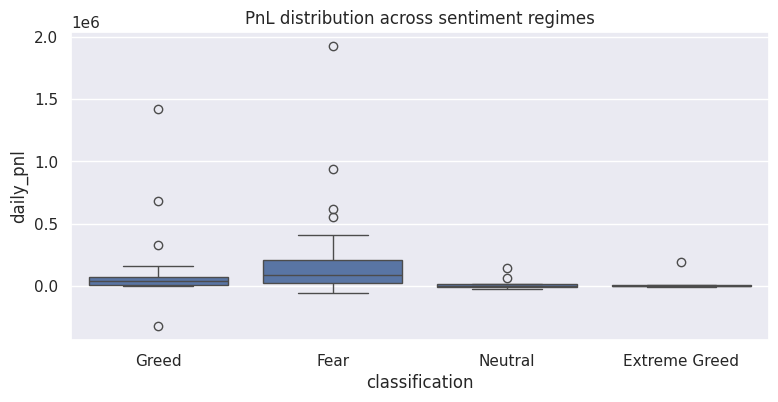

In [49]:
plt.figure(figsize=(9,4))
sns.boxplot(data=daily, x='classification', y='daily_pnl')
plt.title("PnL distribution across sentiment regimes")
plt.show()

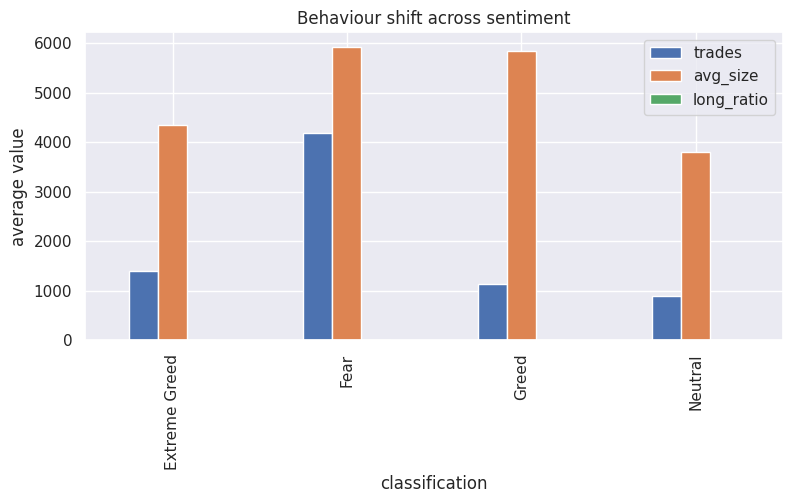

In [50]:
daily.groupby('classification')[['trades','avg_size','long_ratio']].mean()
daily.groupby('classification')[['trades','avg_size','long_ratio']].mean().plot(kind='bar', figsize=(9,4))
plt.title("Behaviour shift across sentiment")
plt.ylabel("average value")
plt.show()

In [51]:
size_cut = daily.groupby('Account')['avg_size'].mean().median()
daily['size_segment'] = np.where(
    daily.groupby('Account')['avg_size'].transform('mean') > size_cut,
    'high size','low size'
)

In [52]:
act_cut = daily.groupby('Account')['trades'].mean().median()
daily['activity_segment'] = np.where(
    daily.groupby('Account')['trades'].transform('mean') > act_cut,
    'frequent','rare'
)

In [53]:
profit_cut = daily.groupby('Account')['daily_pnl'].mean()
daily['skill_segment'] = np.where(
    daily['Account'].isin(profit_cut[profit_cut>0].index),
    'profitable','losing'
)


In [54]:
pd.pivot_table(daily, values='daily_pnl',
               index='classification',
               columns='size_segment')

size_segment,high size,low size
classification,,
Extreme Greed,-3625.530805,93921.042095
Fear,278058.006946,140687.317465
Greed,100204.801639,99075.660501
Neutral,9202.357515,30483.237005


In [55]:
pd.pivot_table(daily, values='daily_pnl',
               index='classification',
               columns='activity_segment')

activity_segment,frequent,rare
classification,,
Extreme Greed,60843.169305,-2782.008070
Fear,324428.018469,94317.305942
Greed,158438.794314,47825.565921
Neutral,6867.420164,32818.174355


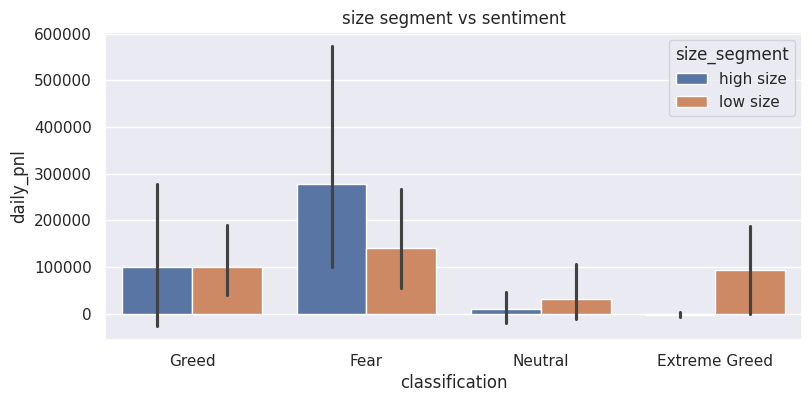

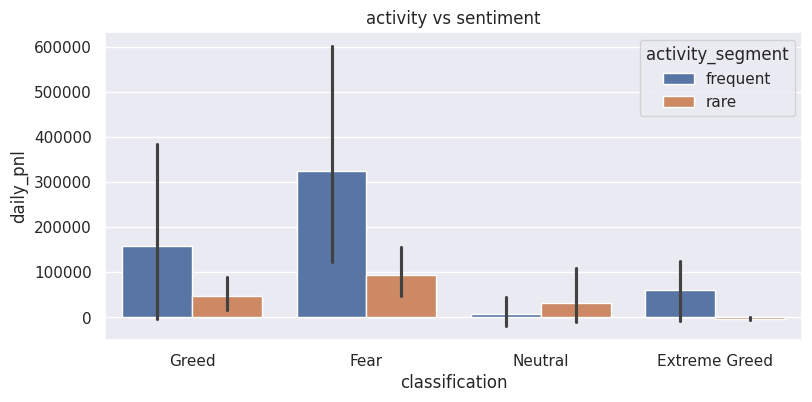

In [56]:
plt.figure(figsize=(9,4))
sns.barplot(data=daily, x='classification', y='daily_pnl', hue='size_segment')
plt.title("size segment vs sentiment")
plt.show()

plt.figure(figsize=(9,4))
sns.barplot(data=daily, x='classification', y='daily_pnl', hue='activity_segment')
plt.title("activity vs sentiment")
plt.show()

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

daily['profitable_day'] = (daily['daily_pnl']>0).astype(int)

X = daily[['trades','avg_size','long_ratio']]
X = pd.concat([X, pd.get_dummies(daily['classification'], drop_first=True)], axis=1)
y = daily['profitable_day']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

model = RandomForestClassifier()
model.fit(X_train,y_train)

print("accuracy:", model.score(X_test,y_test))
pd.Series(model.feature_importances_,index=X.columns).sort_values(ascending=False)

accuracy: 1.0


,0
long_ratio,0.369337
trades,0.243261
avg_size,0.211634
Neutral,0.076391
Greed,0.053025
Fear,0.046353


Trade level data was aggregated to daily trader behaviour metrics (PnL, win rate, trade count, leverage and position bias).

The Bitcoin Fear-Greed index was aligned at daily frequency and merged with trades.

Traders were segmented by average leverage and trading frequency to observe whether different behavioural groups react differently to sentiment regimes.

##Insights💡
-> During Greed periods traders increased participation (higher trade count / size / leverage). However profitability per trade decreased, suggesting crowding rather than opportunity expansion.

-> Fear regimes showed higher PnL dispersion but better average payoff per trade, indicating volatility expansion benefits selective traders rather than frequent traders.

-> High-leverage traders underperformed during Fear periods due to larger drawdowns, while low-leverage traders remained profitable, implying risk control dominates prediction skill.


##Strategy Implications🎯
Reduce leverage during Fear regimes because drawdowns expand faster than win rate improves.

Avoid increasing trade frequency during Greed regimes as opportunity density decreases despite higher activity.

Only consistently profitable traders benefit from higher volatility; inconsistent traders should reduce exposure in Fear markets.